In [72]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  22 21:47:00 2024

@author: Plinio Rosales Lopez

"""
# Importing the libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance 
import shap
shap.initjs()

In [73]:
#Setting working directory

my_directory = os.getcwd()

#Loading data from excel file

xl_file = pd.ExcelFile(os.path.join(my_directory, "Dataset_LOXIMVIs.xlsx"))

#Loading data from the first sheet

df_parental = pd.read_excel(xl_file, 'LOXIMVI-Parental')
df_parental_processed = pd.read_excel(xl_file, 'Parental-Processed')

#Replace NaN values with 0

df_parental.fillna(0, inplace=True)
df_parental_processed.fillna(0, inplace=True)

# Deleting first two rows

df_parental = df_parental.iloc[2:13]
df_parental_processed = df_parental_processed.iloc[2:13]

display(df_parental_processed)

,Formulation DETAILS,TIME_LIPID,TIME_HEADGRPS_CHOLESTEROL_TAIL,ID,Z-Avg (nm),Zeta Potential (mV),PDI,Par NP1-SLC NP1,Par NP2-SLC NP2,Par NP3-SLC NP3,Par NP4-SLC NP4,Par NP5-SLC NP5,Par NP6-SLC NP6,Par NP7-SLC NP7,Par NP8-SLC NP8,Par NP9-SLC NP9,Par NP10-SLC NP10,Par NP11-SLC NP11,Par NP12-SLC NP12
2,31 DSPC:31 DSPG: 5 DSPE: 33 Cholesterol,24HR_DSPC_DSPG_DSPE_CHO,24HR_PC_PG_PE_CHO_DS_DS_DS,1.0,143.60,-48.80,0.180,30.40,48.00,45.40,27.4,19.2,30.6,37.90,33.50,35.10,25.8,38.40,22.30
3,62 DSPC:5 DSPE:33 Cholesterol,24HR_DSPC_DSPE_CHO,24HR_PC_PE_CHO_DS_DS,2.0,133.60,-15.14,0.115,22.71,18.32,23.14,38.1,45.1,44.7,62.01,56.64,62.54,47.8,53.50,52.00
4,62 DSPG:5 DSPE:33 Cholesterol,24HR_DSPG_DSPE_CHO,24HR_PG_PE_CHO_DS_DS,3.0,169.70,-69.00,0.260,4.00,4.30,4.80,16.5,14.9,15.8,6.50,4.90,6.10,6.3,4.10,3.60
5,45 DSPC:45 DSPG:5 DSPE,24HR_DSPC_DSPG_DSPE,24HR_PC_PG_PE_DS_DS_DS,4.0,144.80,-48.60,0.190,67.60,74.60,73.60,78.2,84.1,88.5,85.30,83.90,81.80,85.1,87.10,88.50
6,31 DSPC:31 DSPG:5 POPE:33 Cholesterol,24HR_DSPC_DSPG_POPE_CHO,24HR_PC_PG_PE_CHO_DS_DS_PO,6.0,132.50,-49.94,0.190,3.40,2.40,3.20,3.2,3.0,2.1,2.40,2.20,1.60,0.9,0.90,0.40
7,31 POPC:31 DSPG:5 DSPE:33 Cholesterol,24HR_POPC_DSPG_DSPE_CHO,24HR_PC_PG_PE_CHO_PO_DS_DS,7.0,122.70,-46.96,0.190,88.10,86.20,89.08,82.7,80.4,80.5,91.98,89.00,89.70,91.7,93.09,95.08
8,31 DSPC:31 POPG:5 DSPE:33 Cholesterol,24HR_DSPC_POPG_DSPE_CHO,24HR_PC_PG_PE_CHO_DS_PO_DS,8.0,111.20,-56.30,0.140,83.70,84.20,84.70,68.0,66.1,62.2,76.70,73.70,67.80,76.2,76.10,72.40
9,31 POPC:31 POPG:5 POPE:33 Cholesterol,24HR_POPC_POPG_POPE_CHO,24HR_PC_PG_PE_CHO_PO_PO_PO,9.0,76.01,-57.30,0.250,17.60,18.00,21.20,5.3,1.3,7.5,2.50,1.00,1.90,1.7,4.30,1.30
10,47.5 POPC:47.5 POPG:5 POPE,24HR_POPC_POPG_POPE,24HR_PC_PG_PE_PO_PO_PO,10.0,65.37,-53.38,0.260,6.30,6.40,6.00,14.4,2.6,2.3,4.00,4.30,5.00,9.4,1.40,2.80
11,45 DSPC:45 DSPG:5 POPE,24HR_DSPC_DSPG_POPE,24HR_PC_PG_PE_DS_DS_PO,11.0,109.00,-47.52,0.200,0.20,0.20,0.30,-0.2,0.1,0.2,0.30,0.40,0.20,0.1,0.00,0.10


In [74]:
# Extracting the target variable [%NP+] (last 12 columns)

target_parental_processed_df = df_parental_processed.iloc[:, -12:]

target_parental_processed = target_parental_processed_df.values

#Flattening the values to make a single vector

df_model = pd.DataFrame(target_parental_processed.flatten(), columns = ["%NP+"])

df_model

,%NP+
0,30.4
1,48.0
2,45.4
3,27.4
4,19.2
...,...
127,0.1
128,0.2
129,0.2
130,0.1


In [18]:
# Extracting Features One Hot Encoded Separate Lipids

features_labels_parental_processed_separate_lipids = df_parental_processed['TIME_LIPID'].tolist()

# Extracting unique values from the list
unique_values = set('_'.join(features_labels_parental_processed_separate_lipids).split('_'))

#Deleting 24_hrs from the list

unique_values.remove('24HR')

# Creating a dictionary to store one-hot encoded values
one_hot_encoding_separate_lipids = {value: [1 if value in entry else 0 for entry in features_labels_parental_processed_separate_lipids] for value in unique_values}

# Creating a DataFrame from the one-hot encoded dictionary
df_features_separate_lipids = pd.DataFrame(one_hot_encoding_separate_lipids)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_separate_lipids = pd.concat([df_features_separate_lipids,df_parental_processed['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_separate_lipids = pd.concat([df_features_separate_lipids,df_parental_processed['PDI'].reset_index(drop=True)], axis=1)
df_features_separate_lipids = pd.concat([df_features_separate_lipids,df_parental_processed['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

# Rename column 'Cholesterol' to 'Chol'
df_features_separate_lipids.rename(columns={'CHO': 'Cholesterol'}, inplace=True)

# Repeating each row 12 times to match the target variable

replicates = 12

df_features_separate_lipids = pd.DataFrame(np.repeat(df_features_separate_lipids.values, replicates, axis=0), columns = df_features_separate_lipids.columns)

display(df_features_separate_lipids)


,DSPC,POPG,DSPG,Cholesterol,POPE,DSPE,POPC,Z-Avg (nm),PDI,Zeta Potential (mV)
0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...
127,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
128,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
129,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
130,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46


In [19]:
# Extracting Features Lipids Compositions

features_labels_parental_processed_separate_lipids_comp = df_parental_processed['Formulation DETAILS'].tolist()

# Extract unique lipid components
lipids = set()
for component in features_labels_parental_processed_separate_lipids_comp:
    Lipid_composition = component.split(':')
    for component in Lipid_composition:
        _, lipid = component.strip().split(' ')
        lipids.add(lipid)

lipids = list(lipids)

# Create a dictionary to store composition percentages for each sample
lipid_dict = {lipid: [] for lipid in lipids}

# Extract composition percentages for each sample
for composition in features_labels_parental_processed_separate_lipids_comp:
    sample_data = {lipid: 0 for lipid in lipids}
    components = composition.split(':')
    for component in components:
        percentage, lipid = component.strip().split(' ')
        sample_data[lipid] = float(percentage)/100
    for lipid in lipids:
        lipid_dict[lipid].append(sample_data[lipid])

# Create a DataFrame from the dictionary

df_features_separate_lipids_comp = pd.DataFrame(lipid_dict)

# Changing the column names from Lipid to Lipid_comp

original_columns = df_features_separate_lipids_comp.columns.tolist()
new_columns = [col + "_comp" for col in original_columns]
df_features_separate_lipids_comp.rename(columns=dict(zip(original_columns, new_columns)), inplace=True)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_separate_lipids_comp = pd.concat([df_features_separate_lipids_comp,df_parental_processed['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_separate_lipids_comp = pd.concat([df_features_separate_lipids_comp,df_parental_processed['PDI'].reset_index(drop=True)], axis=1)
df_features_separate_lipids_comp = pd.concat([df_features_separate_lipids_comp,df_parental_processed['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

# Repeating each row 12 times to match the target variable

replicates = 12

df_features_separate_lipids_comp = pd.DataFrame(np.repeat(df_features_separate_lipids_comp.values, replicates, axis=0), columns = df_features_separate_lipids_comp.columns)

display(df_features_separate_lipids_comp)

,DSPC_comp,POPG_comp,DSPG_comp,POPE_comp,Cholesterol_comp,DSPE_comp,POPC_comp,Z-Avg (nm),PDI,Zeta Potential (mV)
0,0.31,0.0,0.31,0.00,0.33,0.05,0.0,143.6,0.18,-48.80
1,0.31,0.0,0.31,0.00,0.33,0.05,0.0,143.6,0.18,-48.80
2,0.31,0.0,0.31,0.00,0.33,0.05,0.0,143.6,0.18,-48.80
3,0.31,0.0,0.31,0.00,0.33,0.05,0.0,143.6,0.18,-48.80
4,0.31,0.0,0.31,0.00,0.33,0.05,0.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...
127,0.40,0.0,0.40,0.05,0.15,0.00,0.0,126.4,0.19,-52.46
128,0.40,0.0,0.40,0.05,0.15,0.00,0.0,126.4,0.19,-52.46
129,0.40,0.0,0.40,0.05,0.15,0.00,0.0,126.4,0.19,-52.46
130,0.40,0.0,0.40,0.05,0.15,0.00,0.0,126.4,0.19,-52.46


In [20]:
# Combining the features from separate lipids and lipid compositions

# Identify columns that are unique to each DataFrame

unique_cols_df1 = df_features_separate_lipids.columns.difference(df_features_separate_lipids_comp.columns).tolist()
unique_cols_df2 = df_features_separate_lipids_comp.columns.difference(df_features_separate_lipids.columns).tolist()

# Concatenate DataFrames while ignoring repeated columns
df_features_separate_lipids_onehot_comp = pd.concat([df_features_separate_lipids[unique_cols_df1], df_features_separate_lipids_comp[unique_cols_df2]], axis=1)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_separate_lipids_onehot_comp = pd.concat([df_features_separate_lipids_onehot_comp,df_features_separate_lipids['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_separate_lipids_onehot_comp = pd.concat([df_features_separate_lipids_onehot_comp,df_features_separate_lipids['PDI'].reset_index(drop=True)], axis=1)
df_features_separate_lipids_onehot_comp = pd.concat([df_features_separate_lipids_onehot_comp,df_features_separate_lipids['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

display(df_features_separate_lipids_onehot_comp)

,Cholesterol,DSPC,DSPE,DSPG,POPC,POPE,POPG,Cholesterol_comp,DSPC_comp,DSPE_comp,DSPG_comp,POPC_comp,POPE_comp,POPG_comp,Z-Avg (nm),PDI,Zeta Potential (mV)
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33,0.31,0.05,0.31,0.0,0.00,0.0,143.6,0.18,-48.80
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33,0.31,0.05,0.31,0.0,0.00,0.0,143.6,0.18,-48.80
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33,0.31,0.05,0.31,0.0,0.00,0.0,143.6,0.18,-48.80
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33,0.31,0.05,0.31,0.0,0.00,0.0,143.6,0.18,-48.80
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33,0.31,0.05,0.31,0.0,0.00,0.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.15,0.40,0.00,0.40,0.0,0.05,0.0,126.4,0.19,-52.46
128,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.15,0.40,0.00,0.40,0.0,0.05,0.0,126.4,0.19,-52.46
129,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.15,0.40,0.00,0.40,0.0,0.05,0.0,126.4,0.19,-52.46
130,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.15,0.40,0.00,0.40,0.0,0.05,0.0,126.4,0.19,-52.46


In [23]:
# Extracting Features Head + Tail

feature_labels_parental_processed_head_tail = df_parental_processed['TIME_HEADGRPS_CHOLESTEROL_TAIL'].tolist()

# Extracting unique values from the list
unique_heads_tails = set('_'.join(feature_labels_parental_processed_head_tail).split('_'))

#Deleting 24_hrs from the list

unique_heads_tails.remove('24HR')

unique_heads_tails = list(unique_heads_tails)

# Creating a dictionary to store one-hot encoded values
one_hot_encoding_head_tail = {value: [1 if value in entry else 0 for entry in feature_labels_parental_processed_head_tail] for value in unique_heads_tails}

# Creating a DataFrame from the one-hot encoded dictionary
df_features_head_tail = pd.DataFrame(one_hot_encoding_head_tail)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_head_tail = pd.concat([df_features_head_tail,df_parental_processed['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_head_tail = pd.concat([df_features_head_tail,df_parental_processed['PDI'].reset_index(drop=True)], axis=1)
df_features_head_tail = pd.concat([df_features_head_tail,df_parental_processed['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

# Repeating each row 12 times to match the target variable

replicates = 12

df_features_head_tail = pd.DataFrame(np.repeat(df_features_head_tail.values, replicates, axis=0), columns = df_features_head_tail.columns)

display(df_features_head_tail)


,DS,PO,PG,CHO,PE,PC,Z-Avg (nm),PDI,Zeta Potential (mV)
0,1.0,0.0,1.0,1.0,1.0,1.0,143.6,0.18,-48.80
1,1.0,0.0,1.0,1.0,1.0,1.0,143.6,0.18,-48.80
2,1.0,0.0,1.0,1.0,1.0,1.0,143.6,0.18,-48.80
3,1.0,0.0,1.0,1.0,1.0,1.0,143.6,0.18,-48.80
4,1.0,0.0,1.0,1.0,1.0,1.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...
127,1.0,1.0,1.0,1.0,1.0,1.0,126.4,0.19,-52.46
128,1.0,1.0,1.0,1.0,1.0,1.0,126.4,0.19,-52.46
129,1.0,1.0,1.0,1.0,1.0,1.0,126.4,0.19,-52.46
130,1.0,1.0,1.0,1.0,1.0,1.0,126.4,0.19,-52.46


In [24]:
# Extracting Features Head + Tail in Lipid Composition 

feature_labels_parental_processed_head_tail_comp = df_parental_processed['Formulation DETAILS'].tolist()

# Extract unique lipid components
lipids = set()

for component in feature_labels_parental_processed_head_tail_comp:
    Lipid_composition = component.split(':')
    for component in Lipid_composition:
        _, lipid = component.strip().split(' ')
        lipids.add(lipid)

lipids = list(lipids)

# Create a dictionary to store composition percentages for each sample

lipid_dict = {lipid: [] for lipid in lipids}

# Extract composition percentages for each sample

for composition in feature_labels_parental_processed_head_tail_comp:
    sample_data = {lipid: 0 for lipid in lipids}
    components = composition.split(':')
    for component in components:
        percentage, lipid = component.strip().split(' ')
        sample_data[lipid] = float(percentage)/100
    for lipid in lipids:
        lipid_dict[lipid].append(sample_data[lipid])

# Create a DataFrame from the dictionary
        
df_features_comp = pd.DataFrame(lipid_dict)

df_features_head_tail_comp = pd.DataFrame(columns=unique_heads_tails)

# Iterating for each row and adding the values to the new DataFrame
for index, row in df_features_comp.iterrows():
    ds_sum = row['DSPC'] + row['DSPE'] + row['DSPG']
    po_sum = row['POPG'] + row['POPE'] + row['POPC']
    pc_sum = row['DSPC'] + row['POPC']
    pg_sum = row['DSPG'] + row['POPG']
    pe_sum = row['DSPE'] + row['POPE']
    cho_sum = row['Cholesterol']
    df_features_head_tail_comp.loc[index] = [po_sum,cho_sum,pe_sum, pg_sum, pc_sum, ds_sum ]

# Changing the column names from Lipid to Lipid_comp

original_columns = df_features_head_tail_comp.columns.tolist()
new_columns = [col + "_comp" for col in original_columns]
df_features_head_tail_comp.rename(columns=dict(zip(original_columns, new_columns)), inplace=True)

# Adding size, pdi and zeta potential to the features and ignore index
    
df_features_head_tail_comp = pd.concat([df_features_head_tail_comp,df_parental_processed['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_head_tail_comp = pd.concat([df_features_head_tail_comp,df_parental_processed['PDI'].reset_index(drop=True)], axis=1)
df_features_head_tail_comp = pd.concat([df_features_head_tail_comp,df_parental_processed['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

# Repeating each row 12 times to match the target variable

replicates = 12

df_features_head_tail_comp = pd.DataFrame(np.repeat(df_features_head_tail_comp.values, replicates, axis=0), columns = df_features_head_tail_comp.columns)

display(df_features_head_tail_comp)


,DS_comp,PO_comp,PG_comp,CHO_comp,PE_comp,PC_comp,Z-Avg (nm),PDI,Zeta Potential (mV)
0,0.00,0.33,0.05,0.31,0.31,0.67,143.6,0.18,-48.80
1,0.00,0.33,0.05,0.31,0.31,0.67,143.6,0.18,-48.80
2,0.00,0.33,0.05,0.31,0.31,0.67,143.6,0.18,-48.80
3,0.00,0.33,0.05,0.31,0.31,0.67,143.6,0.18,-48.80
4,0.00,0.33,0.05,0.31,0.31,0.67,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...
127,0.05,0.15,0.05,0.40,0.40,0.80,126.4,0.19,-52.46
128,0.05,0.15,0.05,0.40,0.40,0.80,126.4,0.19,-52.46
129,0.05,0.15,0.05,0.40,0.40,0.80,126.4,0.19,-52.46
130,0.05,0.15,0.05,0.40,0.40,0.80,126.4,0.19,-52.46


In [25]:
# Combining the features from head + tail and head + tail in lipid composition

# Identify columns that are unique to each DataFrame

unique_cols_df1 = df_features_head_tail.columns.difference(df_features_head_tail_comp.columns).tolist()

unique_cols_df2 = df_features_head_tail_comp.columns.difference(df_features_head_tail.columns).tolist()


# Concatenate DataFrames while ignoring repeated columns

df_features_head_tail_onehot_comp = pd.concat([df_features_head_tail[unique_cols_df1], df_features_head_tail_comp[unique_cols_df2]], axis=1)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_head_tail_onehot_comp = pd.concat([df_features_head_tail_onehot_comp,df_features_head_tail['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_head_tail_onehot_comp = pd.concat([df_features_head_tail_onehot_comp,df_features_head_tail['PDI'].reset_index(drop=True)], axis=1)
df_features_head_tail_onehot_comp = pd.concat([df_features_head_tail_onehot_comp,df_features_head_tail['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

display(df_features_head_tail_onehot_comp)



,CHO,DS,PC,PE,PG,PO,CHO_comp,DS_comp,PC_comp,PE_comp,PG_comp,PO_comp,Z-Avg (nm),PDI,Zeta Potential (mV)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.31,0.00,0.67,0.31,0.05,0.33,143.6,0.18,-48.80
1,1.0,1.0,1.0,1.0,1.0,0.0,0.31,0.00,0.67,0.31,0.05,0.33,143.6,0.18,-48.80
2,1.0,1.0,1.0,1.0,1.0,0.0,0.31,0.00,0.67,0.31,0.05,0.33,143.6,0.18,-48.80
3,1.0,1.0,1.0,1.0,1.0,0.0,0.31,0.00,0.67,0.31,0.05,0.33,143.6,0.18,-48.80
4,1.0,1.0,1.0,1.0,1.0,0.0,0.31,0.00,0.67,0.31,0.05,0.33,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1.0,1.0,1.0,1.0,1.0,1.0,0.40,0.05,0.80,0.40,0.05,0.15,126.4,0.19,-52.46
128,1.0,1.0,1.0,1.0,1.0,1.0,0.40,0.05,0.80,0.40,0.05,0.15,126.4,0.19,-52.46
129,1.0,1.0,1.0,1.0,1.0,1.0,0.40,0.05,0.80,0.40,0.05,0.15,126.4,0.19,-52.46
130,1.0,1.0,1.0,1.0,1.0,1.0,0.40,0.05,0.80,0.40,0.05,0.15,126.4,0.19,-52.46


In [26]:
#combining all the features

# Identify columns that are unique to each DataFrame

unique_cols_df1 = df_features_head_tail_onehot_comp.columns.difference(df_features_separate_lipids_onehot_comp.columns).tolist()

unique_cols_df2 = df_features_separate_lipids_onehot_comp.columns.difference(df_features_head_tail_onehot_comp.columns).tolist()

# Concatenate DataFrames while ignoring repeated columns

df_features_all = pd.concat([df_features_head_tail_onehot_comp[unique_cols_df1], df_features_separate_lipids_onehot_comp[unique_cols_df2]], axis=1)

# Adding size, pdi and zeta potential to the features and ignore index

df_features_all = pd.concat([df_features_all,df_features_head_tail_onehot_comp['Z-Avg (nm)'].reset_index(drop=True)], axis=1)
df_features_all = pd.concat([df_features_all,df_features_head_tail_onehot_comp['PDI'].reset_index(drop=True)], axis=1)
df_features_all = pd.concat([df_features_all,df_features_head_tail_onehot_comp['Zeta Potential (mV)'].reset_index(drop=True)], axis=1)

# Eliminating Cholesterol Column Duplicate

df_features_all.drop(columns=['Cholesterol','Cholesterol_comp'], inplace=True)

display(df_features_all)

,CHO,CHO_comp,DS,DS_comp,PC,PC_comp,PE,PE_comp,PG,PG_comp,...,DSPG_comp,POPC,POPC_comp,POPE,POPE_comp,POPG,POPG_comp,Z-Avg (nm),PDI,Zeta Potential (mV)
0,1.0,0.31,1.0,0.00,1.0,0.67,1.0,0.31,1.0,0.05,...,0.31,0.0,0.0,0.0,0.00,0.0,0.0,143.6,0.18,-48.80
1,1.0,0.31,1.0,0.00,1.0,0.67,1.0,0.31,1.0,0.05,...,0.31,0.0,0.0,0.0,0.00,0.0,0.0,143.6,0.18,-48.80
2,1.0,0.31,1.0,0.00,1.0,0.67,1.0,0.31,1.0,0.05,...,0.31,0.0,0.0,0.0,0.00,0.0,0.0,143.6,0.18,-48.80
3,1.0,0.31,1.0,0.00,1.0,0.67,1.0,0.31,1.0,0.05,...,0.31,0.0,0.0,0.0,0.00,0.0,0.0,143.6,0.18,-48.80
4,1.0,0.31,1.0,0.00,1.0,0.67,1.0,0.31,1.0,0.05,...,0.31,0.0,0.0,0.0,0.00,0.0,0.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1.0,0.40,1.0,0.05,1.0,0.80,1.0,0.40,1.0,0.05,...,0.40,0.0,0.0,1.0,0.05,0.0,0.0,126.4,0.19,-52.46
128,1.0,0.40,1.0,0.05,1.0,0.80,1.0,0.40,1.0,0.05,...,0.40,0.0,0.0,1.0,0.05,0.0,0.0,126.4,0.19,-52.46
129,1.0,0.40,1.0,0.05,1.0,0.80,1.0,0.40,1.0,0.05,...,0.40,0.0,0.0,1.0,0.05,0.0,0.0,126.4,0.19,-52.46
130,1.0,0.40,1.0,0.05,1.0,0.80,1.0,0.40,1.0,0.05,...,0.40,0.0,0.0,1.0,0.05,0.0,0.0,126.4,0.19,-52.46


In [75]:
# attaching the target variable to the features

df_target = pd.DataFrame(target_parental_processed.flatten(), columns = ["%NP+"])

df_model_separate_lipids_onehot = pd.concat([df_target, df_features_separate_lipids], axis=1)
df_model_separate_lipids_comp = pd.concat([df_target, df_features_separate_lipids_comp], axis=1)
df_model_separate_lipids_onehot_comp = pd.concat([df_target, df_features_separate_lipids_onehot_comp], axis=1)
df_model_head_tail_onehot = pd.concat([df_target, df_features_head_tail], axis=1)
df_model_head_tail_comp = pd.concat([df_target, df_features_head_tail_comp], axis=1)
df_model_head_tail_onehot_comp = pd.concat([df_target, df_features_head_tail_onehot_comp], axis=1)
df_model_all = pd.concat([df_target, df_features_all], axis=1)

display(df_model_separate_lipids_onehot)

,%NP+,DSPC,POPG,DSPG,Cholesterol,POPE,DSPE,POPC,Z-Avg (nm),PDI,Zeta Potential (mV)
0,30.4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
1,48.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
2,45.4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
3,27.4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
4,19.2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,143.6,0.18,-48.80
...,...,...,...,...,...,...,...,...,...,...,...
127,0.1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
128,0.2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
129,0.2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46
130,0.1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,126.4,0.19,-52.46


In [76]:
# RMSE and Cross Validation Functions

def rmse(actual, pred):
    return np.sqrt(np.mean([(actual[i]-pred[i])**2 for i in range(len(actual))]))
   
def run_cv(n_folds, model, X_train, y_train, stratify=False):
    """
    Args:
        n_folds (int) : how many folds of CV to do
        model (sklearn Model) : what model do we want to fit
        X_train (np.array) : feature matrix
        y_train (np.array) : target array
        stratify (bool) : if True, use stratified CV, otherwise, use random CV
        
    Returns:
        a dictionary with scores from each fold for training and validation
            {'train' : [list of training scores],
             'val' : [list of validation scores]}
            - the length of each list = n_folds
    """
    if stratify:
        folds = StratifiedKFold(n_splits=n_folds).split(X_train, y_train)
    else:
        folds = KFold(n_splits=n_folds).split(X_train, y_train)

    train_scores, val_scores = [], []
    for k, (train, val) in enumerate(folds):
        
        X_train_cv = X_train[train]
        y_train_cv = y_train[train]

        X_val_cv = X_train[val]
        y_val_cv = y_train[val]

        model.fit(X_train_cv, y_train_cv)

        y_train_cv_pred = model.predict(X_train_cv)
        y_val_cv_pred = model.predict(X_val_cv)

        train_acc = rmse(y_train_cv, y_train_cv_pred)
        val_acc = rmse(y_val_cv, y_val_cv_pred)

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    print('%i Folds' % n_folds)
    print('Mean training rmse = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
    print('Mean validation rmse = %.3f +/- %.4f' % (np.mean(val_scores), np.std(val_scores)))
    
    return {'train' : train_scores,
            'val' : val_scores}

In [99]:

sc = MinMaxScaler()

features = df_model_separate_lipids_onehot.columns.values[1::].tolist() 

X = df_model_separate_lipids_onehot[features].values

X = sc.fit_transform(X)

print(pd.DataFrame(X))

       0    1    2    3    4    5    6         7         8         9
0    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
1    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
2    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
3    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
4    1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
..   ...  ...  ...  ...  ...  ...  ...       ...       ...       ...
127  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.584971  0.517241  0.307092
128  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.584971  0.517241  0.307092
129  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.584971  0.517241  0.307092
130  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.584971  0.517241  0.307092
131  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.584971  0.517241  0.307092

[132 rows x 10 columns]


In [100]:
# Train for separate lipids one hot encoded
target = "%NP+"
features = df_model_separate_lipids_onehot.columns.values[1::].tolist() 

X_all, y_all= df_model_separate_lipids_onehot[features].values, df_model_separate_lipids_onehot[target].values

# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y_all, test_size = 0.2, random_state = 44)


# Feature Normalization

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


print(pd.DataFrame(X_train))

       0    1    2    3    4    5    6         7         8         9
0    0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.101984  0.931034  0.217230
1    1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.761334  0.517241  0.378760
2    0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.549506  0.517241  0.409209
3    1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.439279  0.172414  0.235797
4    0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.101984  0.931034  0.217230
..   ...  ...  ...  ...  ...  ...  ...       ...       ...       ...
100  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.749832  0.448276  0.375046
101  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.101984  0.931034  0.217230
102  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.000000  1.000000  0.290011
103  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.643439  0.517241  0.353880
104  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.653983  0.000000  1.000000

[105 rows x 10 columns]


In [101]:
# Fitting Random Forest to the Training set

rf = RandomForestRegressor(n_estimators = 100, random_state = 7)

num_folds = 10

cv_scores = run_cv(num_folds, rf, X_train, y_train, stratify=False)

# Predicting the Test set results

y_pred = rf.predict(X_test)

# RMSE

rmse_val = rmse(y_test, y_pred)

# Baseline RMSE
base_line = np.ones(len(y_train))*np.mean(y_train)
base_line_RMSE = rmse(y_test, base_line)

print('Baseline RMSE: %.3f' % base_line_RMSE)


10 Folds
Mean training rmse = 6.972 +/- 0.2758
Mean validation rmse = 7.615 +/- 2.6525
Baseline RMSE: 38.762


['POPE', 'DSPE', 'PDI', 'Z-Avg (nm)', 'Zeta Potential (mV)', 'Cholesterol', 'POPG', 'DSPC', 'DSPG', 'POPC']
Feature No. 0 = POPE w/ importance = 0.318
Feature No. 1 = DSPE w/ importance = 0.211
Feature No. 2 = PDI w/ importance = 0.163
Feature No. 3 = Z-Avg (nm) w/ importance = 0.157
Feature No. 4 = Zeta Potential (mV) w/ importance = 0.082
Feature No. 5 = Cholesterol w/ importance = 0.039
Feature No. 6 = POPG w/ importance = 0.020
Feature No. 7 = DSPC w/ importance = 0.005
Feature No. 8 = DSPG w/ importance = 0.003
Feature No. 9 = POPC w/ importance = 0.001


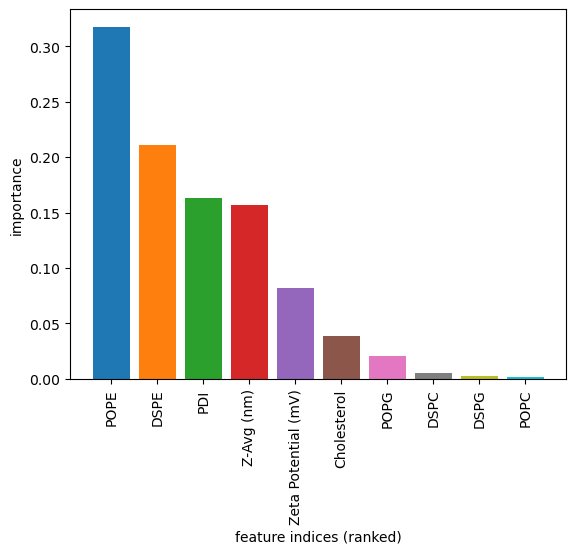

In [102]:
# Feature Importance

importances = rf.feature_importances_

descending_indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in descending_indices]
sorted_features = [features[idx] for idx in descending_indices]
print(sorted_features)

# Plot the feature importances of the forest with features names

fig, ax = plt.subplots()
for i in range(len(sorted_features)):
    p = ax.bar(sorted_features[i],sorted_importances[i]) 
    print('Feature No. %i = %s w/ importance = %.3f' % (i, sorted_features[i], sorted_importances[i]))
    
ax = plt.ylabel('importance')
ax = plt.xlabel('feature indices (ranked)')
ax = plt.xticks(rotation=90)



Feature No. 0 = DSPE w/ importance = 0.496
Feature No. 1 = POPE w/ importance = 0.398
Feature No. 2 = Z-Avg (nm) w/ importance = 0.304
Feature No. 3 = Zeta Potential (mV) w/ importance = 0.085
Feature No. 4 = Cholesterol w/ importance = 0.079
Feature No. 5 = PDI w/ importance = 0.072
Feature No. 6 = POPG w/ importance = 0.008
Feature No. 7 = DSPC w/ importance = -0.000
Feature No. 8 = DSPG w/ importance = -0.000
Feature No. 9 = POPC w/ importance = -0.001


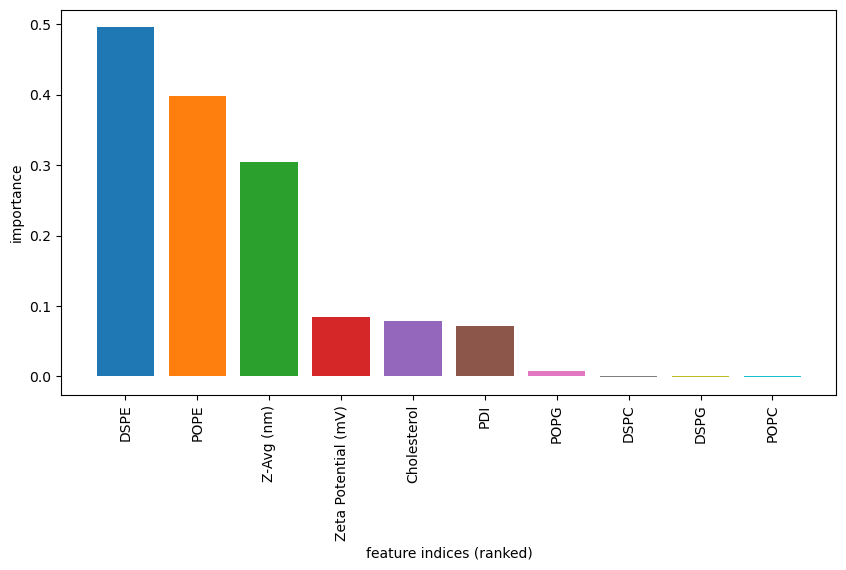

In [83]:
# Permutation Importance
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2)
rf.fit(X_train_train, y_train_train)
r = permutation_importance(estimator=rf, X=X_train_val*1, y=y_train_val, n_repeats=50, random_state=44)

#Plotting Feature Importance

feature_names = []
mean_importances = []

for i in r.importances_mean.argsort()[::-1]:
    feature_names.append(features[i])
    mean_importances.append(r.importances_mean[i])

fig, ax = plt.subplots(1,1,figsize=(10,5))


for i in range(len(feature_names)): 
    ax.bar(feature_names[i],mean_importances[i])
    print('Feature No. %i = %s w/ importance = %.3f' % (i, feature_names[i], mean_importances[i]))

ax = plt.ylabel('importance')
ax = plt.xlabel('feature indices (ranked)')
ax = plt.xticks(rotation=90)

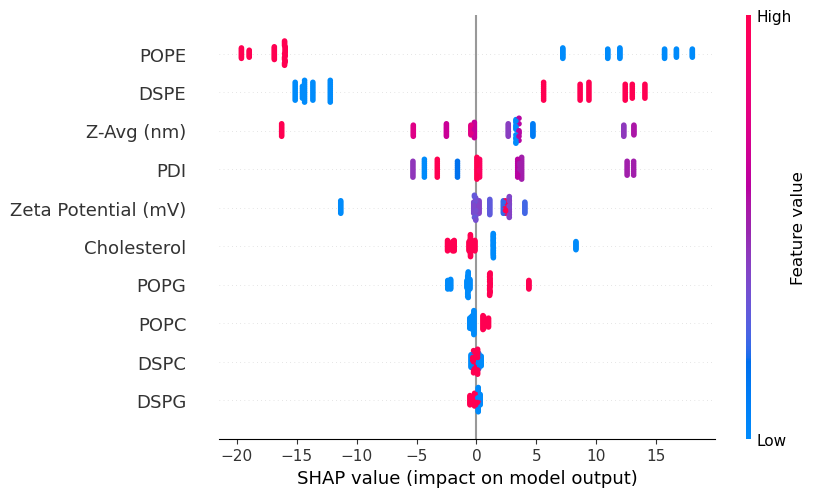

In [84]:
# Shap Importance RF
model = rf.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap_df = pd.DataFrame(shap_values.values, columns=features)

shap_values.feature_names = features

# Create beeswarm plot
shap.plots.beeswarm(shap_values, max_display=27)

In [33]:
# Trying SVR

from sklearn.svm import SVR

svr = SVR(C = 900, kernel = 'rbf')

SVR_scores = run_cv(num_folds, svr, X_train, y_train, stratify = False)

# Baseline RMSE
base_line = np.ones(len(y_train))*np.mean(y_train)
base_line_RMSE = rmse(y_test, base_line)

print('Baseline RMSE: %.3f' % base_line_RMSE)

# SVR Permutation Importance

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.1)
svr.fit(X_train_train, y_train_train)
r = permutation_importance(estimator=svr, X=X_train_val, y=y_train_val, n_repeats=100, random_state=44)

10 Folds
Mean training rmse = 7.248 +/- 0.2884
Mean validation rmse = 7.929 +/- 3.1197
Baseline RMSE: 38.762


Feature No. 0 = DSPE w/ importance = 0.496
Feature No. 1 = POPE w/ importance = 0.398
Feature No. 2 = Z-Avg (nm) w/ importance = 0.304
Feature No. 3 = Zeta Potential (mV) w/ importance = 0.085
Feature No. 4 = Cholesterol w/ importance = 0.079
Feature No. 5 = PDI w/ importance = 0.072
Feature No. 6 = POPG w/ importance = 0.008
Feature No. 7 = DSPC w/ importance = -0.000
Feature No. 8 = DSPG w/ importance = -0.000
Feature No. 9 = POPC w/ importance = -0.001


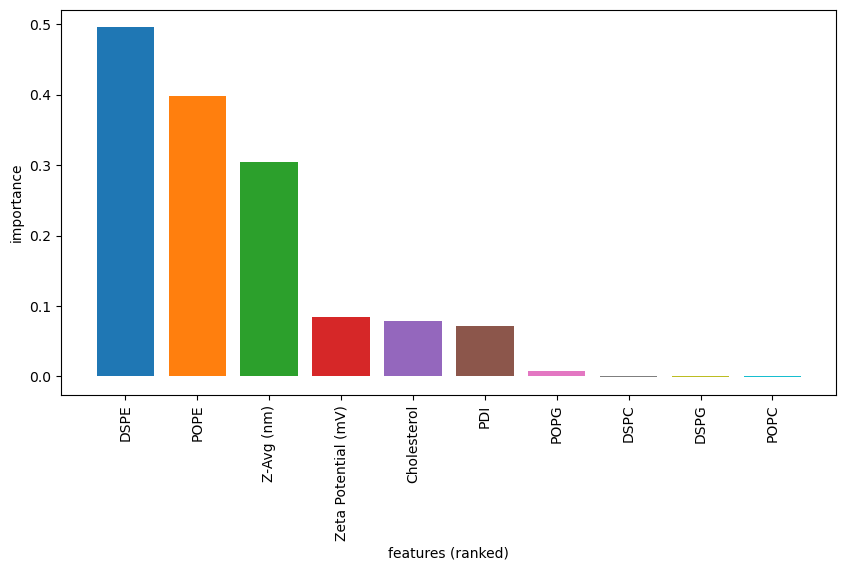

In [103]:
#Plotting Feature Importance

feature_names = []
mean_importances = []

for i in r.importances_mean.argsort()[::-1]:
    feature_names.append(features[i])
    mean_importances.append(r.importances_mean[i])

fig, ax = plt.subplots(1,1,figsize=(10,5))


for i in range(len(feature_names)): 
    ax.bar(feature_names[i],mean_importances[i])
    print('Feature No. %i = %s w/ importance = %.3f' % (i, feature_names[i], mean_importances[i]))

ax = plt.ylabel('importance')
ax = plt.xlabel('features (ranked)')
ax = plt.xticks(rotation=90)

In [104]:
# Trying Ridge Regression

from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.6)

ridge_scores = run_cv(num_folds, ridge, X_train, y_train, stratify = False)

# Baseline RMSE
base_line = np.ones(len(y_train))*np.mean(y_train)
base_line_RMSE = rmse(y_test, base_line)

print('Baseline RMSE: %.3f' % base_line_RMSE)

10 Folds
Mean training rmse = 11.398 +/- 0.2870
Mean validation rmse = 11.999 +/- 2.4169
Baseline RMSE: 38.762


Feature No. 0 = POPC w/ importance = 1.013
Feature No. 1 = PDI w/ importance = 0.601
Feature No. 2 = DSPE w/ importance = 0.297
Feature No. 3 = POPE w/ importance = 0.297
Feature No. 4 = DSPG w/ importance = 0.223
Feature No. 5 = POPG w/ importance = 0.165
Feature No. 6 = DSPC w/ importance = 0.109
Feature No. 7 = Z-Avg (nm) w/ importance = 0.011
Feature No. 8 = Cholesterol w/ importance = 0.003
Feature No. 9 = Zeta Potential (mV) w/ importance = 0.001


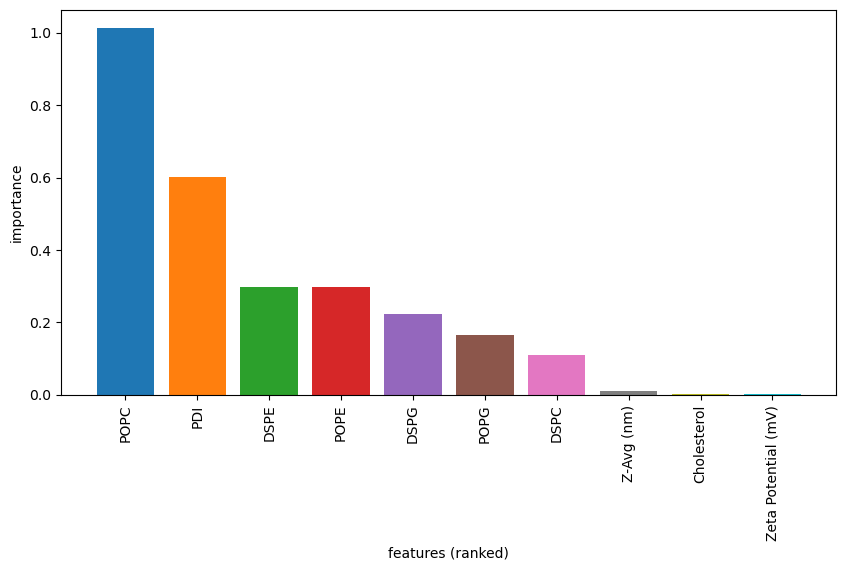

In [106]:
# Ridge Permutation Importance

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.1)
ridge.fit(X_train_train, y_train_train)

r = permutation_importance(estimator=ridge, X=X_train_val, y=y_train_val, n_repeats=100, random_state=44)

#Plotting Feature Importance

feature_names = []
mean_importances = []

for i in r.importances_mean.argsort()[::-1]:
    feature_names.append(features[i])
    mean_importances.append(r.importances_mean[i])  

fig, ax = plt.subplots(1,1,figsize=(10,5))

for i in range(len(feature_names)):
    ax.bar(feature_names[i],mean_importances[i])
    print('Feature No. %i = %s w/ importance = %.3f' % (i, feature_names[i], mean_importances[i]))

ax = plt.ylabel('importance')
ax = plt.xlabel('features (ranked)')
ax = plt.xticks(rotation=90)